In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

### Data loading

In [3]:
data_path = '../data/processed/usc-had.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,subject,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,activity
0,11,0.788496,0.429586,0.158079,-9.520525,1.719961,-0.391400,2
1,11,0.795364,0.425966,0.176379,-8.312029,-0.693527,0.414264,2
2,11,0.819400,0.454920,0.205661,-5.492205,-3.495776,1.622760,2
3,11,0.815967,0.454920,0.212981,0.147443,-5.509936,0.817096,2
4,11,0.840003,0.454920,0.209321,3.772932,-9.135425,-0.794232,2


In [5]:
FEATURES = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
LABEL = 'activity'

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [7]:
NOVEL_CLASSES = [3,4,10,11]

In [8]:
holdout_data = df.loc[df[LABEL].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [9]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['uschad_preprocess']

In [10]:
train_subject = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
val_subject = [12]
test_subject = [13, 14]

In [11]:
train_df = df.loc[df['subject'].isin(train_subject)]
val_df = df.loc[df['subject'].isin(val_subject)]
test_df = df.loc[df['subject'].isin(test_subject)]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_val = X_val.reshape(
    (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
X_holdout, y_holdout = create_windowed_dataset(novel_data, FEATURES,LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
y_holdout = tf.keras.utils.to_categorical(y_holdout)

In [13]:
print(X_train.shape)
print(y_train.shape)

(12566, 10, 20, 6)
(12566, 13)


In [14]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=metadata['n_window'], axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=metadata['n_window'], axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=metadata['n_window'], axis=1)

In [15]:
y_holdout_mid = np.repeat(np.expand_dims(y_holdout, axis=1), repeats=N_WINDOW, axis=1)

In [16]:
y_train_mid.shape

(12566, 10, 13)

In [17]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'uschad'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

8 Physical GPUs, 8 Logical GPUs


In [18]:
tf.keras.backend.clear_session()
device_list = ['/gpu:'+str(i) for i in range(7, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:7',)
Number of devices: 1


In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 20, 6)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 128),  989952      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_1 (Modal (None, None, 128)    675968      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 128), (None, 329600      modality_encoder_block_1[0][0]   
____________________________________________________________________________________________

In [20]:
checkpoint_filepath = "usc_checkpoints_vae/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               verbose=1)

In [21]:
history = model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=30, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True )

Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

In [22]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 128)

In [23]:
activity_map = { 1:'Walking Forward', 2:'Walking Left', 5:'Walking Downstairs', 6:'Running Forward',
                7:'Jumping Up', 8:'Sitting', 9:'Standing', 12:'Elevator Down'}
activity_list = list(activity_map.values())

In [24]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels=list(activity_map.keys()), target_names=activity_list))

                    precision    recall  f1-score   support

   Walking Forward       0.89      0.64      0.75       764
      Walking Left       0.59      0.60      0.60       481
Walking Downstairs       0.29      0.54      0.38       180
   Running Forward       1.00      0.76      0.86       401
        Jumping Up       0.82      0.85      0.84       179
           Sitting       0.80      0.73      0.76       492
          Standing       0.21      0.20      0.21       340
     Elevator Down       0.14      0.29      0.19       178

          accuracy                           0.60      3015
         macro avg       0.59      0.58      0.57      3015
      weighted avg       0.68      0.60      0.63      3015



<AxesSubplot:>

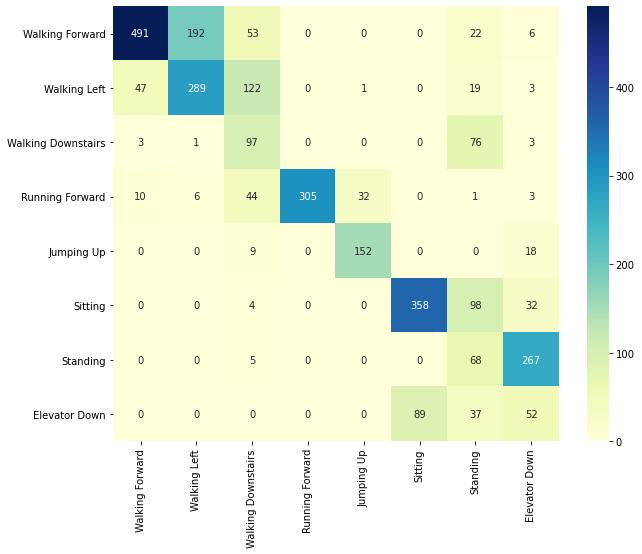

In [25]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [ ]:
y_test_mid.shape

In [ ]:
pred_mid.shape

In [ ]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1), labels=list(activity_map.keys()), target_names=activity_list))

In [ ]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

## VAE

In [26]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_1
combined_sensor_self_attention_1
tf_op_layer_Shape
tf_op_layer_ExpandDims
tf_op_layer_strided_slice_1
tf_op_layer_strided_slice_2
tf_op_layer_Tile
tf_op_layer_concat
tf_op_layer_Reshape
reshape
concatenate
dense_36
dense_37
window_pred
session_pred


In [27]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [28]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 20, 6)]       0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 128), (None 989952    
_________________________________________________________________
modality_encoder_block_1 (Mo (None, None, 128)         675968    
_________________________________________________________________
combined_sensor_self_attenti ((None, 128), (None, 1, N 329600    
Total params: 1,995,520
Trainable params: 0
Non-trainable params: 1,995,520
_________________________________________________________________


In [29]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # _data, label = data
            _data = data
            _data, _ = self.base_model(_data)
            z_mean, z_log_var, z = self.encoder(_data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)            
            reconstruction = tf.keras.losses.mean_squared_error(_data, reconstructed)
            # weighted_reconstruction = tf.math.multiply(reconstruction, label)
            # reconstruction_loss = tf.reduce_mean(weighted_reconstruction)
            reconstruction_loss = tf.reduce_mean(reconstruction)
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Open set training

In [30]:
with strategy.scope():
    hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=128)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

vae_history = hsa_vae.fit(X_train, epochs=60, batch_size=128, verbose=2)

Epoch 1/60
99/99 - 10s - reconstruction_loss: 0.9901 - kl_loss: 0.0831 - loss: 1.0732
Epoch 2/60
99/99 - 10s - reconstruction_loss: 0.8468 - kl_loss: 0.0045 - loss: 0.8513
Epoch 3/60
99/99 - 10s - reconstruction_loss: 0.8145 - kl_loss: 0.0019 - loss: 0.8164
Epoch 4/60
99/99 - 10s - reconstruction_loss: 0.8062 - kl_loss: 9.9122e-04 - loss: 0.8072
Epoch 5/60
99/99 - 10s - reconstruction_loss: 0.8031 - kl_loss: 8.3520e-04 - loss: 0.8040
Epoch 6/60
99/99 - 9s - reconstruction_loss: 0.8003 - kl_loss: 0.0011 - loss: 0.8014
Epoch 7/60
99/99 - 6s - reconstruction_loss: 0.7977 - kl_loss: 0.0019 - loss: 0.7996
Epoch 8/60
99/99 - 6s - reconstruction_loss: 0.7935 - kl_loss: 0.0041 - loss: 0.7976
Epoch 9/60
99/99 - 6s - reconstruction_loss: 0.7866 - kl_loss: 0.0087 - loss: 0.7953
Epoch 10/60
99/99 - 6s - reconstruction_loss: 0.7790 - kl_loss: 0.0133 - loss: 0.7923
Epoch 11/60
99/99 - 6s - reconstruction_loss: 0.7725 - kl_loss: 0.0167 - loss: 0.7892
Epoch 12/60
99/99 - 7s - reconstruction_loss: 0.76

## Novelty Result

In [31]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [32]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [33]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [34]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [35]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [36]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [37]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.75)

              precision    recall  f1-score   support

       KNOWN       0.20      0.36      0.25      3015
       NOVEL       0.74      0.56      0.64      9991

    accuracy                           0.51     13006
   macro avg       0.47      0.46      0.44     13006
weighted avg       0.61      0.51      0.55     13006



In [38]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [39]:
train_rec_loss.shape

(12566,)

In [40]:
novel_rec_loss.shape

(9991,)

<AxesSubplot:ylabel='Probability'>

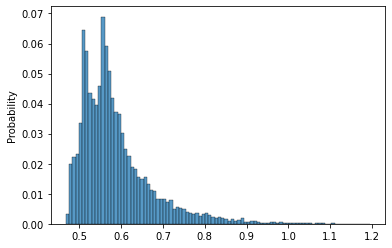

In [41]:
sns.histplot(train_rec_loss, stat="probability")

<AxesSubplot:ylabel='Probability'>

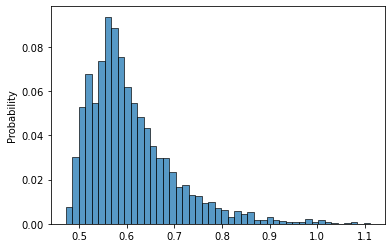

In [42]:
sns.histplot(test_rec_loss, stat="probability")

<AxesSubplot:ylabel='Count'>

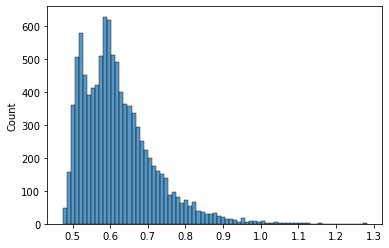

In [43]:
sns.histplot(novel_rec_loss)

<AxesSubplot:xlabel='data', ylabel='Probability'>

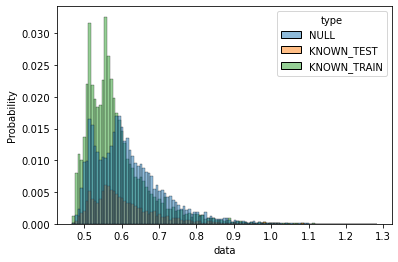

In [44]:
combined = pd.DataFrame({'data': novel_rec_loss, 'type': 'NULL'})
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

<AxesSubplot:xlabel='data', ylabel='Probability'>

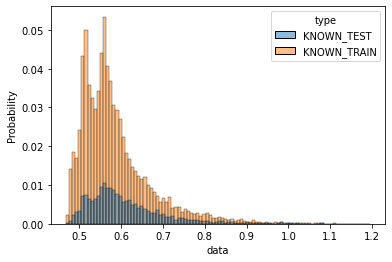

In [45]:
combined = pd.DataFrame()
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

In [46]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [47]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.0, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

In [48]:
from tabulate import tabulate

/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


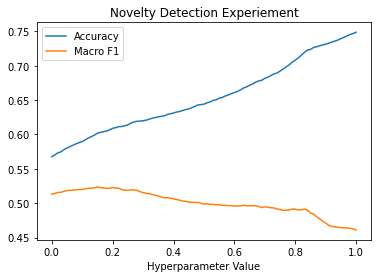

Index with Top Accuracy and Macro F1 :  [100  99  98  97  96] [15 20 16 17 14]
Most Important Index :  []
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0    |   0.567584 |   0.513063 |
+---------+-------------------------+------------+------------+
|       1 |                    0.01 |   0.570198 |   0.514078 |
+---------+-------------------------+------------+------------+
|       2 |                    0.02 |   0.573197 |   0.515535 |
+---------+-------------------------+------------+------------+
|       3 |                    0.03 |   0.574581 |   0.51564  |
+---------+-------------------------+------------+------------+
|       4 |                    0.04 |   0.57781  |   0.517177 |
+---------+-------------------------+------------+------------+
|       5 |                    0.05 |   0.580348 |   0.518235 

In [49]:
# Result
hparam_search() 